In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from pandas import concat
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 42
import os

## 데이터셋 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 딥러닝 - LSTM

In [ ]:
Products = pd.read_csv('/content/drive/MyDrive/teamplay/products_no_china_no_token_v2.csv')

In [ ]:
from keras.preprocessing import sequence

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling1D
from keras.regularizers import l2
from keras.layers import concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
from keras.layers import Concatenate
from keras.layers import Input

In [ ]:
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
import pickle
from tensorflow.keras.models import load_model

## 종속변수 비율 맞추어서 데이터프레임 샘플 생성

In [ ]:
Products.head()

,MEMBER_ID,CATALOG_NM,CATEGORYM_ID,DISPLAY,CATALOG_DESC,INPUT_DT,UPDATE_DT,REMOTEIP,SHOW_CHK,judge
0,shangyuanshibang,1 1 dimethylethyl ester ca 288573 56 8,212815,1,1 name identifiers1 1 name1 boc 4 4 fluoro phe...,20230228,20230228,4237992,1,0
1,shangyuanshibang,white crystal n isopropylbenzylamine ca 102 97...,212815,1,1 name identifiers1 1 namen isopropylbenzylami...,20230228,20230228,4237992,1,0
2,5527,soybean gmo non gmo,11607,1,soja gmo soja non gmoem estoque 5000000 mtorig...,20230228,20230228,131196216214,1,0
3,solvemedic,neuramis lidocaine light deep volume,311699,1,indication neuramis light lidocaine use correc...,20230227,20230227,78159101115,1,0
4,skateline,ccm tack v pro senior ice hockey skate step v ...,36191401,1,ccm tack v pro senior ice hockey skatesnew 202...,20230227,20230227,114122103141,1,0


In [ ]:
df_0 = Products[Products['judge'] == 0].sample(n=90000, random_state=42)
df_1 = Products[Products['judge'] == 1].sample(n=120000, random_state=42)

# Concatenate the DataFrames
new_df = pd.concat([df_0, df_1])

In [ ]:
y = new_df['judge']

In [ ]:
y = pd.DataFrame(y)

## 리스트로 변환

In [ ]:
df1 = []

In [ ]:
df1 = pd.DataFrame(df1)

In [ ]:
def string_to_list(input_string):
    # 문자열을 rhdqor()를 기준으로 나누어 리스트로 변환
    return str(input_string).split(' ')

df1['CATALOG_DESC'] = new_df['CATALOG_DESC'].apply(string_to_list)
df1['CATALOG_NM'] = new_df['CATALOG_NM'].apply(string_to_list)

In [ ]:
df1.head()

,CATALOG_DESC,CATALOG_NM
85645,"[place, order, withus, kindly, contact, usvia]","[mac, retro, matte, liquid, lipcolour, choose,..."
165965,"[📞, place, order, contact, u, whatsapp, 1, 606...","[n95, face, mask]"
144676,"[sugar, bear, hair, vitamin, 60, ct, vegetaria...","[sugar, bear, hair, vitamin, 60, ct, vegetaria..."
18335,"[place, order, whats, app, 1, 702, 4728022]","[olaplexing, 7, bonding, oil, 1, oz]"
22348,"[whatsapp, number, 1, 765, 203, 1619customers,...","[estee, lauder, advanced, night, repair, synch..."


### 독립변수 2개: (CATALOG_DESC, CATALOG_NM)

## 방법 1

In [ ]:
# Step 1: Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(concat([df1['CATALOG_DESC'], df1['CATALOG_NM']]))
vocab_size = len(tokenizer.word_index) + 1

# Step 2: Integer Encoding
sequences_desc = tokenizer.texts_to_sequences(df1['CATALOG_DESC'])
sequences_nm = tokenizer.texts_to_sequences(df1['CATALOG_NM'])

x_desc = pad_sequences(sequences_desc, maxlen=5435, padding='post')
x_nm = pad_sequences(sequences_nm, maxlen=31, padding='post')

# Ensure that the vocabulary size used for the Embedding layer matches the tokenizer's vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Split the data into train and validation sets
X_train_desc, X_test_desc, X_train_nm, X_test_nm, y_train, y_test = train_test_split(
    x_desc, x_nm, y, test_size=0.3, random_state=42
)
# 다시 val과 test분리
X_val_desc, X_test_desc, X_val_nm, X_test_nm, y_val, y_test = train_test_split(X_test_desc, X_test_nm, y_test, test_size=0.5, random_state=40)


In [ ]:
MAX_ALLOWED_LENGTH_DESC = 300  # Adjust based on analysis
MAX_ALLOWED_LENGTH_NM = 20

# Step 1: Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(concat([df1['CATALOG_DESC'], df1['CATALOG_NM']]))
vocab_size = len(tokenizer.word_index) + 1

# Step 2: Integer Encoding
sequences_desc = tokenizer.texts_to_sequences(df1['CATALOG_DESC'])
sequences_nm = tokenizer.texts_to_sequences(df1['CATALOG_NM'])

x_desc = pad_sequences(sequences_desc, maxlen=MAX_ALLOWED_LENGTH_DESC, padding='post')
x_nm = pad_sequences(sequences_nm, maxlen=MAX_ALLOWED_LENGTH_NM, padding='post')

# Ensure that the vocabulary size used for the Embedding layer matches the tokenizer's vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Split the data into train and validation sets
X_train_desc, X_test_desc, X_train_nm, X_test_nm, y_train, y_test = train_test_split(
    x_desc, x_nm, y, test_size=0.3, random_state=42
)
# 다시 val과 test분리
X_val_desc, X_test_desc, X_val_nm, X_test_nm, y_val, y_test = train_test_split(X_test_desc, X_test_nm, y_test, test_size=0.5, random_state=40)


# Define LSTM model for 'CATALOG_DESC'
model_desc = Sequential()
model_desc.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length_desc))
model_desc.add(LSTM(units=100))
model_desc.add(Dropout(0.3))

# Define LSTM model for 'CATALOG_NM'
model_nm = Sequential()
model_nm.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length_nm))
model_nm.add(LSTM(units=100))
model_nm.add(Dropout(0.3))



# Concatenate sequences using Keras Concatenate layer
concat_layer = Concatenate()([model_desc.output, model_nm.output])

# Add additional Dense layer after concatenation if needed
merged = Dense(units=50, activation='relu')(concat_layer)

# Output layer
output_layer = Dense(units=1, activation='sigmoid')(merged)

# Create a new model with the concatenated layers
model_combined = Model(inputs=[model_desc.input, model_nm.input], outputs=output_layer)

# Compile the model
model_combined.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

#Check_point
current_directory = os.getcwd()
# Define the path to the Models folder
models_folder_path = os.path.join(current_directory, 'Models')
# Ensure the Models folder exists, create it if not
os.makedirs(models_folder_path, exist_ok=True)
# Define the checkpoint with the updated filepath
check_point = ModelCheckpoint(
    filepath=os.path.join(models_folder_path, '{epoch:02d}-{val_accuracy:.3f}.hdf5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)


# Train the model using separate validation data
model_combined.fit(
    [X_train_desc, X_train_nm],
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_val_desc, X_val_nm], y_val),
    verbose=1,
    callbacks=[early_stopping, check_point]
)

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 평가

In [ ]:
test_loss, test_accuracy = model_combined.evaluate([X_test_desc, X_test_nm], y_test,verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

985/985 [==============================] - 59s 60ms/step - loss: 0.4282 - accuracy: 0.7976
Test Loss: 0.42818403244018555, Test Accuracy: 0.7975872755050659


In [ ]:
# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/Models/1223_v3.hdf5')

# evaluate-score
score = loaded_model.evaluate([X_test_desc, X_test_nm], y_test ,verbose=1)

# Obtain predictions on the validation set
y_pred = loaded_model.predict([X_val_desc, X_val_nm])

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)
roc_auc = roc_auc_score(y_val, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Print the confusion matrix
print('\n==== Confusion Matrix ====')
conf_matrix = confusion_matrix(y_val, y_pred_binary)
print(conf_matrix)

# Print the classification report
print('\n==== Classification Report ====')
print(classification_report(y_val, y_pred_binary))

985/985 [==============================] - 57s 57ms/step


NameError: ignored

### 새로운 데이터 투입

In [ ]:
import pandas as pd

# 데이터 프레임에 사용할 데이터 생성
data = {
    'CATALOG_NM': ['Air Jordan 1 Mid'],
    'CATALOG_DESC': ['Nike ']
}

# 데이터 프레임 생성
df = pd.DataFrame(data)

# 생성된 데이터 프레임 출력
print(df)

         CATALOG_NM                                       CATALOG_DESC
0  Air Jordan 1 Mid  Never mess with a classic. Keep heritage on yo...


In [ ]:
# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/Models/1223_v3.hdf5')

In [ ]:
tokenizer_path = '/content/drive/MyDrive/Models/tokenizer_v4.pkl'
with open(tokenizer_path, 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

# Load Test Data
test_data_path = '/content/drive/MyDrive/Models/test.csv'
new_data = pd.read_csv(test_data_path)

In [ ]:
new_data = new_data.drop(columns=['Unnamed: 0'])

In [ ]:
new_data.head()

,CATALOG_NM,CATALOG_DESC
0,madeworn rock woman ac dc tee,fabric lightweight jersey crew neck short slee...
1,mielle organic rosemary mint scalp hair streng...,nourish strengthen nutrient rich biotin infuse...
2,facial cleansing brush face scrubber coslus 7i...,aii one cleansing system facial cleansing brus...
3,truskin vitamin c face serum – anti aging face...,skin brightening serum vitamin c even skin ton...
4,beakey 5 pc makeup sponge set latex free high ...,bk makeup blender sponge easy clean reusable m...


In [ ]:
print(sequences_new_desc)
print(sequences_new_nm)

[[660, 11002, 232376, 2381, 446, 15068, 232376, 92, 92, 1137, 660, 1075, 532]]
[[88, 12849, 1, 3138]]


In [ ]:
sequences_new_desc = tokenizer.texts_to_sequences(df['CATALOG_DESC'])
sequences_new_nm = tokenizer.texts_to_sequences(df['CATALOG_NM'])
print(f'Number of sequences in CATALOG_DESC: {len(sequences_new_desc)}')
print(f'Number of sequences in CATALOG_NM: {len(sequences_new_nm)}')

Number of sequences in CATALOG_DESC: 1
Number of sequences in CATALOG_NM: 1


In [ ]:
loaded_model.input_shape[0]

(None, 5435)

In [ ]:
# Adjust the shape of x_new_desc and x_new_nm using the correct sequence length
x_new_desc = pad_sequences(sequences_new_desc, maxlen=5435, padding='post')
x_new_nm = pad_sequences(sequences_new_nm, maxlen=31, padding='post')

# Predict on the New Data
y_pred = loaded_model.predict([x_new_desc, x_new_nm])

# Apply Threshold for Binary Classification
threshold = 0.3
y_pred_binary = (y_pred > threshold).astype(int)



1/1 [==============================] - 0s 78ms/step


In [ ]:
print(y_pred_binary)

[[1]]


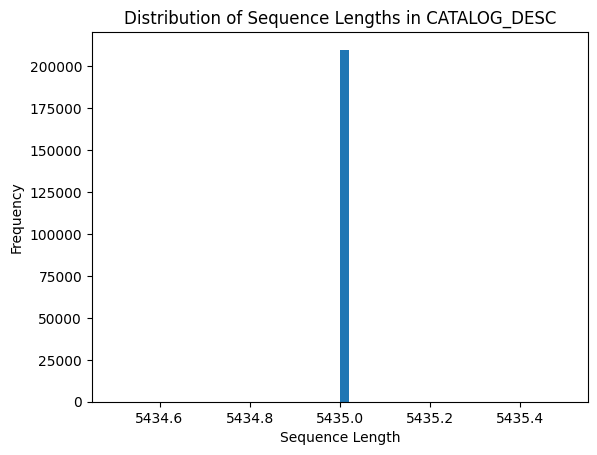

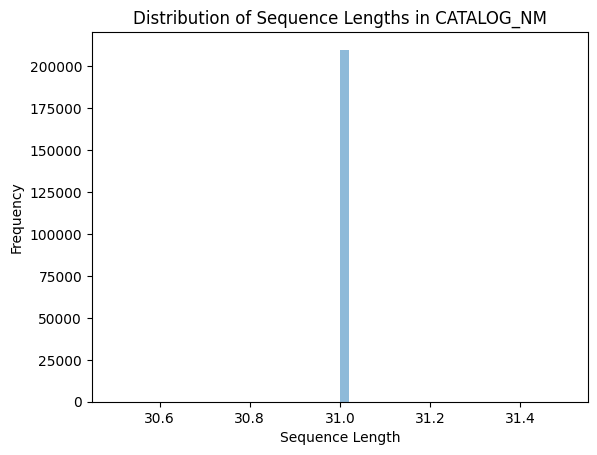

In [ ]:
# Analyze the distribution of sequence lengths
import matplotlib.pyplot as plt

# Plot histogram for CATALOG_DESC
plt.hist([len(seq) for seq in x_desc], bins=50, label='CATALOG_DESC')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in CATALOG_DESC')
plt.show()

# Plot histogram for CATALOG_NM
plt.hist([len(seq) for seq in x_nm], bins=50, label='CATALOG_NM', alpha=0.5)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in CATALOG_NM')
plt.show()

[[390, 1604, 5325, 10863, 2087, 759, 1634, 21503, 19492, 654, 634, 620, 5184, 10681], [10397, 4455, 2143, 985, 6328, 11196, 221, 28, 90, 4891, 142, 265, 4544, 5583, 996, 221, 734, 563, 344, 17000, 142, 585, 24513, 3349, 687, 2719, 537, 1604, 221, 11439, 2719, 537, 8464, 1137, 1386, 537, 142, 2820, 11652, 687, 1184, 5089, 856, 88, 830, 38322, 3851, 11652, 195, 4718, 985, 2885, 89, 1266, 72, 2143, 6327, 9579, 4718, 642, 2505, 7812, 10542, 1167, 16009, 1370, 102, 68, 4455, 20270, 10397, 922, 142, 85, 142, 38, 3359, 9439, 3403, 4718, 142, 7035, 72, 4788, 3823, 142, 142, 38, 6327, 11439, 38, 4012, 7699, 6618, 2520, 142, 10500, 3101, 109, 13, 8291, 320, 142, 1058, 1058, 570474, 599, 2208, 23602, 1058, 142, 38, 532, 1317, 2, 3168, 599, 696, 35143, 249, 1158, 874, 1902, 821, 442, 2269, 978, 2301, 82], [50849, 57, 2953, 39, 673, 2953, 1009, 1172, 3, 6048, 1009, 388, 156, 27, 1, 667, 1009, 388, 1, 87011, 832, 1, 1739, 3964, 2405, 1, 1914, 2270, 1009, 388, 1, 1643, 1009, 388, 570, 31, 1009, 388, 

In [ ]:
print("Model Input Shape:", loaded_model.input_shape)

Model Input Shape: [(None, 5435), (None, 31)]


In [ ]:
print("Shape of x_new_desc:", x_new_desc.shape)
print("Shape of x_new_nm:", x_new_nm.shape)

NameError: ignored